# IT3103 - Assignment 1 - Advanced Topics in AI

## 🌼 Flower Classifier 🌼

### Team Members:
- Tan Qian Peng (234504H)
- Rethika
- Harith

## Introduction

This is a model that classifies flowers by different kinds (i.e. daisy, dandelion, roses, sunflowers, and tulips). In this notebook, we will be presenting our own neural network and how we will program our machine to understand and classify flowers into their own respective types.

The priority of our model would be to ensure that we have more than 70% accuracy, while avoiding as much overlapping as possible.

## Section 1: Data Preparation

Before we start this assignment, we must prepare the necessary dataset for this, so we will install necessary modules first.

In [241]:
import os
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Sequential
from sklearn.metrics import classification_report

In [243]:
dataset_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
path_to_zip = keras.utils.get_file('flower_photos.tgz', origin=dataset_URL, extract=True, cache_dir='.')
dataset_dir = os.path.join(os.path.dirname(path_to_zip), "flower_photos_extracted/flower_photos")
print(dataset_dir)

.\datasets\flower_photos_extracted/flower_photos


In [244]:
daisy_dir = os.path.join(dataset_dir, "daisy")
dandelion_dir = os.path.join(dataset_dir, "dandelion")
roses_dir = os.path.join(dataset_dir, "roses")
sunflowers_dir = os.path.join(dataset_dir, "sunflowers")
tulips_dir = os.path.join(dataset_dir, "tulips")

print('total daisy images:', len(os.listdir(daisy_dir)))
print('total dandelion images:', len(os.listdir(dandelion_dir)))
print('total roses images:', len(os.listdir(roses_dir)))
print('total sunflowers images:', len(os.listdir(sunflowers_dir)))
print('total tulips images:', len(os.listdir(tulips_dir)))

total daisy images: 633
total dandelion images: 898
total roses images: 641
total sunflowers images: 699
total tulips images: 799


### Splitting into training and validation sets

In [246]:
img_height, img_width = 128, 128
batch_size = 32

# resize all the images to the same size as expected by VGG model we downloaded above
image_size = (img_height, img_width)

train_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [247]:
for images, labels in train_ds.take(1):
    print('images shape:', images.shape)
    print('labels shape:', labels.shape)
    print(tf.squeeze(labels))

images shape: (32, 128, 128, 3)
labels shape: (32,)
tf.Tensor([1 4 1 2 4 2 4 0 4 4 4 2 1 3 4 0 3 4 3 4 0 2 3 4 3 4 1 0 1 0 3 4], shape=(32,), dtype=int32)


In [248]:
## print out the class indices
print(train_ds.class_names)
print(val_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Data augmentation

Next, we will use data augmentation in order to applying random horizontal flips, rotations (by 10%), and zooms (by 10%).

This model will visualize the effects of the augmentation by taking one batch of images from the training dataset to be augmented.

Why we use data augmentation is that it expands the training dataset by adding variations that the model might encounter in real-world data.

This helps to avoid overfitting and to improve the model's generalization capabilities, and makes it more robust to minor transformations in input images.

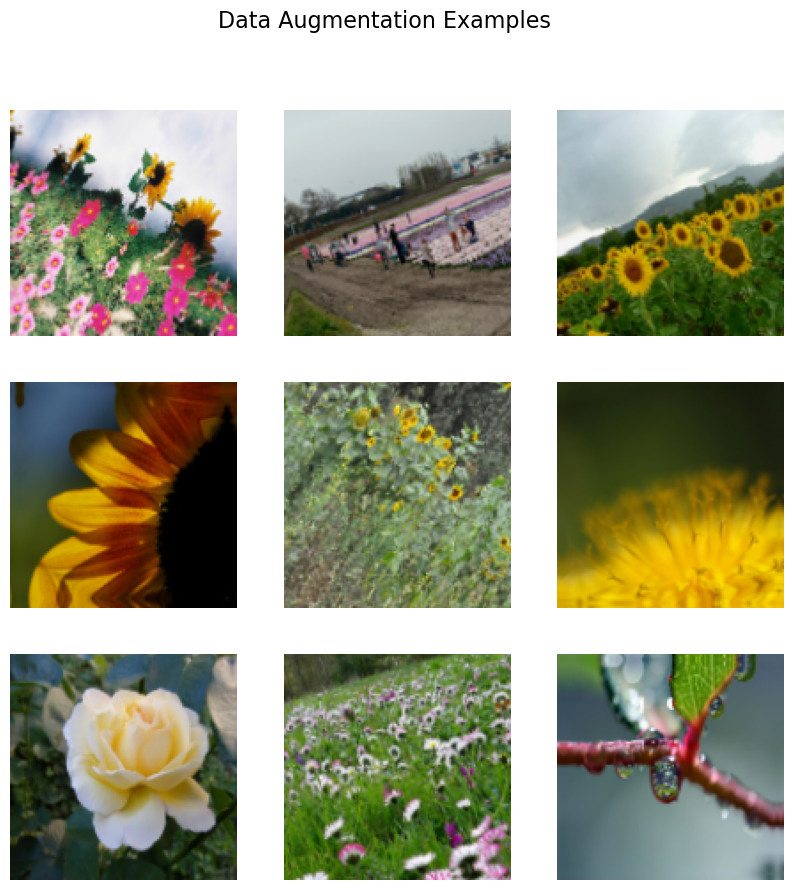

In [251]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# Visualize data augmentation effects
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)[i].numpy().astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
plt.suptitle("Data Augmentation Examples", fontsize=16)
plt.show()

## Section 2: Model Building

### Model Architecture Framework

This CNN model, flower_model, is designed for image classification, specifically for 5 flower categories. It processes 128x128x3 images. The initial Rescaling is meant to normalise pixel values before we start handling layers.

This model employs four convolutional blocks, each with Conv2D, BatchNormalization, ReLU activation, and MaxPooling2D for feature extraction and dimensionality reduction. `BatchNormalization` stabilizes training, and ReLU introduces non-linearity. Dropout layers of 0.2 and 0.5 are strategically placed after the third convolutional block and in the dense head to prevent overfitting by randomly deactivating neurons.

The Classifier Head uses GlobalAveragePooling2D to flatten features efficiently, followed by a Dense layer with ReLu and another Dropout layer. The final Dense layer with softmax activation outputs probabilities for the 5 classes, making it suitable for multi-class classification. This architecture is common for image classification tasks, balancing feature learning with regularization.

In [255]:
def flower_model():
    num_classes = 5  # daisy, dandelion, roses, sunflowers, tulips

    # Calling sequential model
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(128, 128, 3))) 
    model.add(keras.layers.Rescaling(scale=1./255))

    # 1st layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same')) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # 2nd layer
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # 3rd layer
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.2)) 

    # 4th layer
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # Classifier Head
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    return model

model = make_model()
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 259,397 (1013.27 KB)

 Trainable params: 258,693 (1010.52 KB)

 Non-trainable params: 704 (2.75 KB)

### Model Compilation and Training

This code compiles and trains the previously defined CNN model.

We chose sparse_categorical_crossentropy as it classifies labels as integers (sparse) and there are multiple classes for each of the five flowers. This measures the difference predicted probabilities and the true labels.

We chose the Adam algorithm as it is known for its good efficiency and performance in many deep learning tasks. Here, we configured the learning rate of 1e-4 as it allows the model to learn without diverging or getting stuck in local minima.

We also chose accuracy as a metric in order to monitor training progress, as it directly reflects the proportion of correctly classified samples, which is a common and intuitive measure for classification tasks.

Finally, The model will iterate over the entire training dataset through the epoch function 30 times. This number is a hyperparameter chosen to allow sufficient time for the model to learn patterns from the data, but not so many as to cause significant overfitting.

In [258]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [259]:
epochs = 30  # We're doing 30 epochs by default
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 699ms/step - accuracy: 0.3397 - loss: 1.6491 - val_accuracy: 0.2493 - val_loss: 1.7012
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 638ms/step - accuracy: 0.5010 - loss: 1.2293 - val_accuracy: 0.2493 - val_loss: 1.8759
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 648ms/step - accuracy: 0.5713 - loss: 1.0894 - val_accuracy: 0.2888 - val_loss: 1.7790
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 635ms/step - accuracy: 0.6120 - loss: 1.0147 - val_accuracy: 0.3801 - val_loss: 1.5686
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 648ms/step - accuracy: 0.6194 - loss: 0.9870 - val_accuracy: 0.4837 - val_loss: 1.2308
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 636ms/step - accuracy: 0.6362 - loss: 0.9332 - val_accuracy: 0.6322 - val_loss: 0.9911
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 640ms/step - accuracy: 0.6650 - loss: 0.9031 - val_accuracy: 0.6785 - val_loss: 0.8876
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 648ms/step - accuracy: 0.6607 - loss: 0.8818 - val_accu